In [1]:
import topostats as topo
from topostats import filters
from topostats import io
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import logging
LOGGER = logging.getLogger()
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import feature
import skimage.filters
import skimage.measure
import skimage.morphology
import skimage.color
import cv2
import scipy.ndimage as ndimage

## Define useful functions

In [89]:
def plane_tilt_removal(image: np.ndarray):
    read_matrix = image.copy()
    # Line of best fit
    # Calculate medians
    medians_x = [np.nanmedian(read_matrix[:, i]) for i in range(read_matrix.shape[1])]
    medians_y = [np.nanmedian(read_matrix[j, :]) for j in range(read_matrix.shape[0])]

    # Fit linear x
    px = np.polyfit(range(0, len(medians_x)), medians_x, 1)
    LOGGER.info(f"x-polyfit 1st order: {px}")
    py = np.polyfit(range(0, len(medians_y)), medians_y, 1)
    LOGGER.info(f"y-polyfit 1st order: {py}")

    if px[0] != 0:
        if not np.isnan(px[0]):
            LOGGER.info(f"Removing x plane tilt")
            for row in range(0, image.shape[0]):
                for col in range(0, image.shape[1]):
                    image[row, col] -= px[0] * (col)
        else:
            LOGGER.info(f"x gradient is nan, skipping plane tilt x removal")
    else:
        LOGGER.info("x gradient is zero, skipping plane tilt x removal")

    if py[0] != 0:
        if not np.isnan(py[0]):
            LOGGER.info(f"removing y plane tilt")
            for row in range(0, image.shape[0]):
                for col in range(0, image.shape[1]):
                    image[row, col] -= py[0] * (row)
        else:
            LOGGER.info("y gradient is nan, skipping plane tilt y removal")
    else:
        LOGGER.info("y gradient is zero, skipping plane tilt y removal")

    return image

def remove_quadratic( image: np.ndarray, mask: np.ndarray = None, order: int=2):
        """
        Removes the quadratic bowing that can be seen in some large-scale AFM images. It uses a simple quadratic fit
        on the medians of the columns of the image and then subtracts the calculated quadratic from the columns.

        Parameters
        ----------
        image: np.ndarray
            2-D image of the data to remove the quadratic from.
        mask: np.ndarray
            Boolean array of points to mask out (ignore).

        Returns
        -------
        np.ndarray
            Returns a copy of the input image with the quadratic bowing removed
        """
        image = image.copy()
        if mask is not None:
            read_matrix = np.ma.masked_array(image, mask=mask, fill_value=np.nan).filled()
            LOGGER.info(f"Remove quadratic bow with mask")
        else:
            read_matrix = image
            LOGGER.info(f"Remove quadratic bow without mask")

        # Calculate the median over the horizontal direction. (axis=0 since that's the dimension in which the median is taken for each
        # element of the median array)
        col_medians = np.nanmedian(read_matrix, axis=0) 

        # Fit the row median data to a polynomial
        coeffs = np.polyfit(range(0, read_matrix.shape[1]), col_medians, order)
        LOGGER.info(f"x polyfit nth order: {coeffs}")
        row_fit = np.polyval(coeffs, range(0, read_matrix.shape[1]))

        for row in range(0, read_matrix.shape[0]):
            image[row, :] -= row_fit

        return image

def scale_heightmap(heightmap):
    heightmap = heightmap.astype(np.float32)
    min_value = heightmap.min()
    max_value = heightmap.max()
    heightmap = (heightmap - min_value) / (max_value - min_value)
    heightmap = heightmap * 255
    heightmap = heightmap.astype(np.uint8)
    return heightmap

def plot(img, title=''):
    plt.imshow(img)
    plt.title(title)
    plt.show()

def plot_with_means(img: np.ndarray, title: str=''):
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    ax[0].imshow(img)
    ax[0].set_title('image')
    ax[1].plot(np.nanmedian(img, axis=0))
    ax[1].set_title('axis: 0')
    ax[2].plot(np.nanmedian(img, axis=1))
    ax[2].set_title('axis: 1')
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

# Load file

[Mon, 06 Mar 2023 15:13:56] [INFO    ] [topostats] Extracting image from ibw/AR101_FAPbBr3_ITO.ibw
[Mon, 06 Mar 2023 15:13:56] [INFO    ] [topostats] Loading image from : ibw/AR101_FAPbBr3_ITO.ibw
[Mon, 06 Mar 2023 15:13:56] [INFO    ] [topostats] [AR101_FAPbBr3_ITO] : Loaded image from : ibw/AR101_FAPbBr3_ITO.ibw
[Mon, 06 Mar 2023 15:13:56] [INFO    ] [topostats] [AR101_FAPbBr3_ITO] : Extracted channel ZSensorRetrace
[Mon, 06 Mar 2023 15:13:56] [INFO    ] [topostats] [AR101_FAPbBr3_ITO] : Pixel to nm scaling : 9.765625
[Mon, 06 Mar 2023 15:13:56] [INFO    ] [topostats] Loading image from : ibw/AR101_FAPbBr3_ITO.ibw
[Mon, 06 Mar 2023 15:13:56] [INFO    ] [topostats] [AR101_FAPbBr3_ITO] : Loaded image from : ibw/AR101_FAPbBr3_ITO.ibw
[Mon, 06 Mar 2023 15:13:56] [INFO    ] [topostats] [AR101_FAPbBr3_ITO] : Extracted channel ZSensorRetrace
[Mon, 06 Mar 2023 15:13:56] [INFO    ] [topostats] [AR101_FAPbBr3_ITO] : Pixel to nm scaling : 9.765625


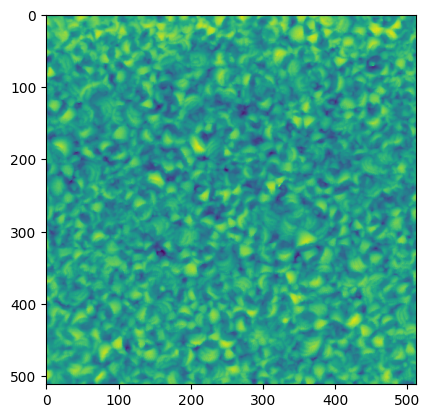

In [78]:
# file = Path('./perovskite/20230207_Me4_NPs_perov_10um.0_00007.spm')
file = Path('./ibw/AR101_FAPbBr3_ITO.ibw')
loadscan = io.LoadScans(img_paths = [file], channel='ZSensorRetrace')
loadscan.get_data()
data, pixel_to_nm = loadscan.load_ibw()
# data, pixel_to_nm = loadscan.load_spm()
plt.imshow(data)
plt.show()

# Flatten

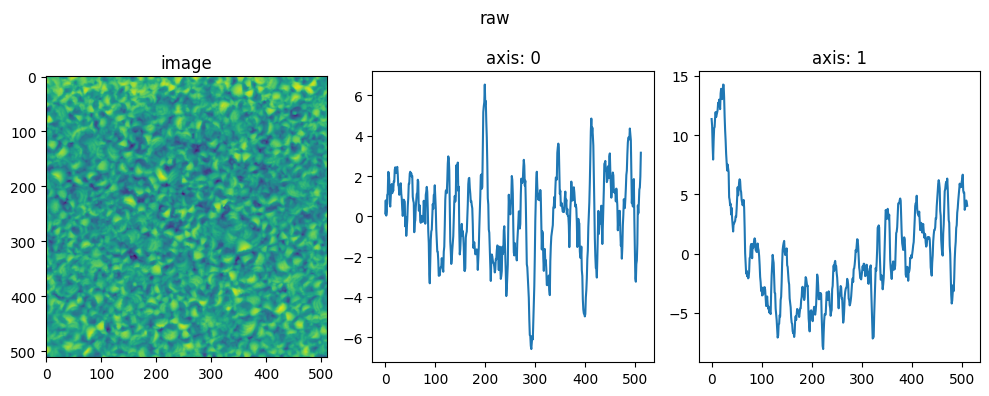

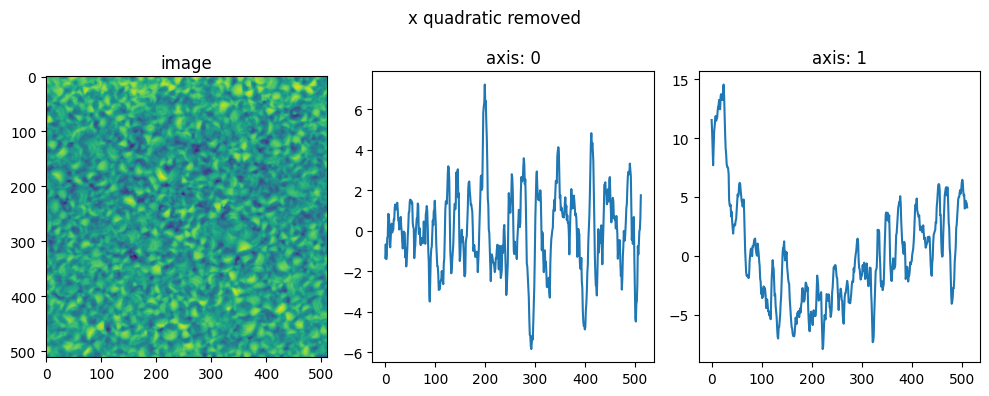

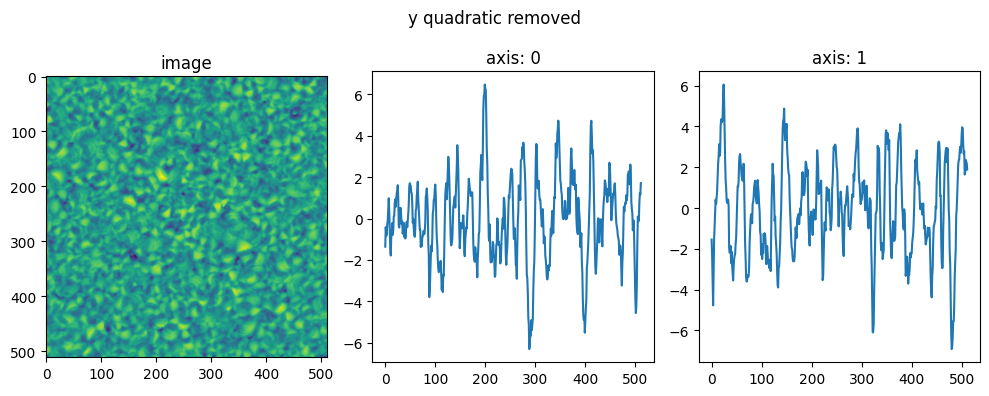

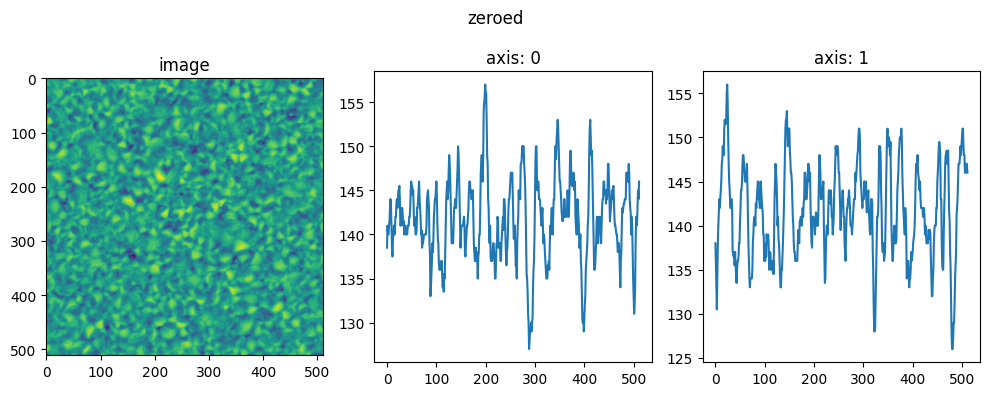

In [90]:
#  Flatten image
img = data.copy()
plot_with_means(img, title='raw')
# img = plane_tilt_removal(img)
# plot_with_means(img, title='plane removed')
img = remove_quadratic(img, order=3)
plot_with_means(img, title='x quadratic removed')
img = remove_quadratic(img.T, order=3).T
plot_with_means(img, title='y quadratic removed')
img = scale_heightmap(img)
plot_with_means(img, title='zeroed')

flattened = img.copy()

# Segment

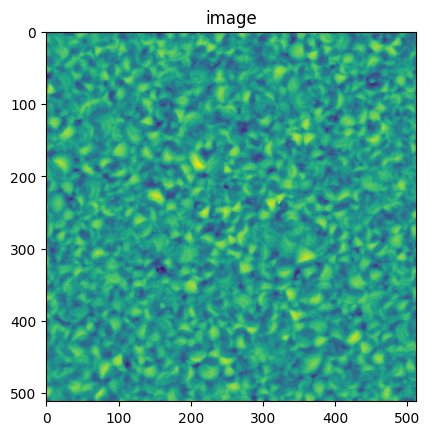

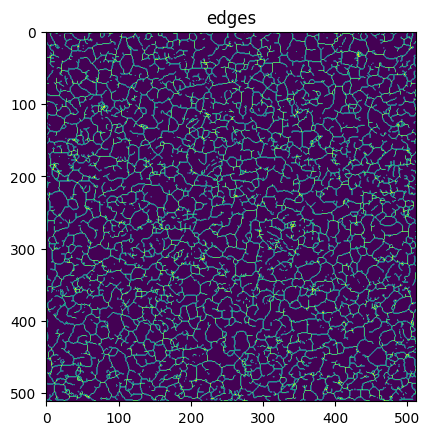

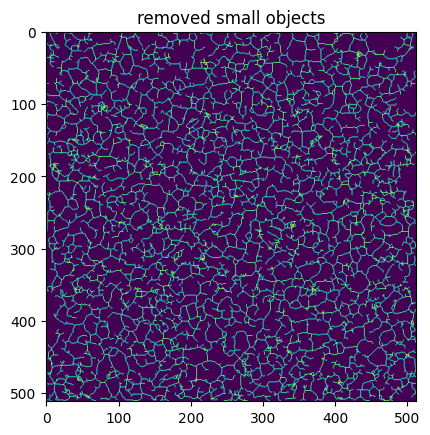

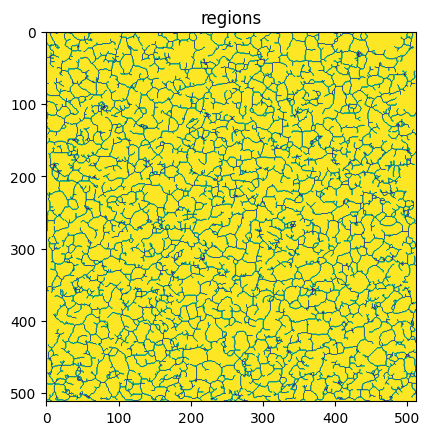

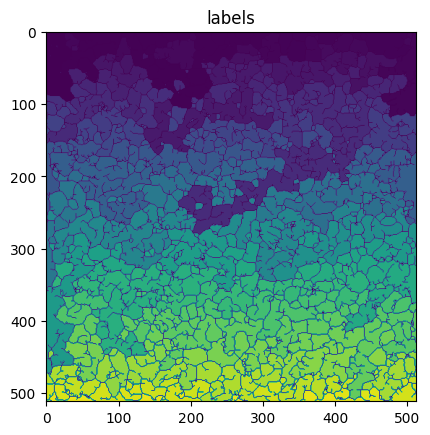

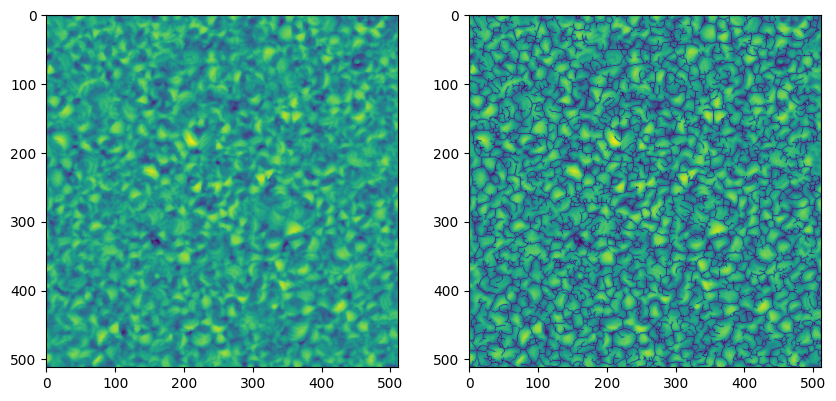

In [91]:
img = flattened.copy()
img = plane_tilt_removal(img)
img = scale_heightmap(img)
plot(img, 'image')
img4 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 0)
img5 = skimage.img_as_ubyte(skimage.morphology.skeletonize(skimage.img_as_bool(img4)))
img6 = cv2.dilate(img5, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=1)
edges = (img5 != 0)
plot(edges, 'edges')
edges = skimage.morphology.remove_small_objects(edges.astype(bool),connectivity=8 ,min_size=100)
plot(edges, 'removed small objects')
masked_img = np.ma.masked_array(img, edges, fill_value=5).filled()

regions = np.invert(edges)
plot(regions, 'regions')

labels = skimage.measure.label(regions, connectivity=1)
plot(labels, 'labels')

fig, ax = plt.subplots(1, 2, figsize=(10, 20))
ax[0].imshow(img)
ax[1].imshow(masked_img)
plt.show()

# Experimental section

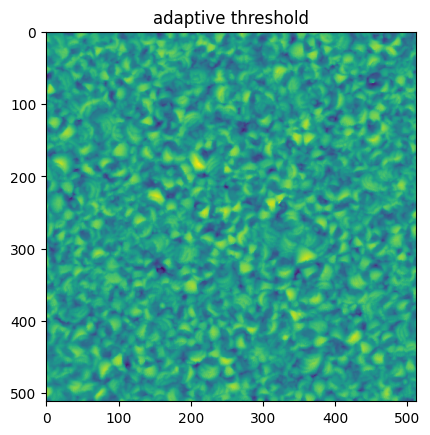

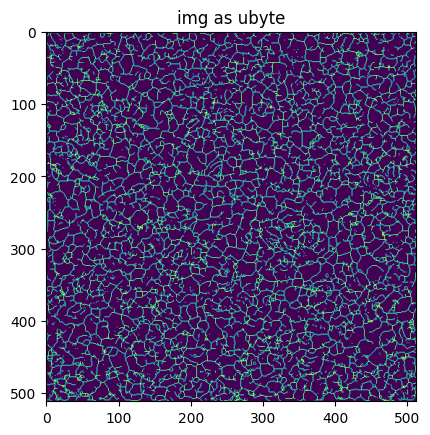

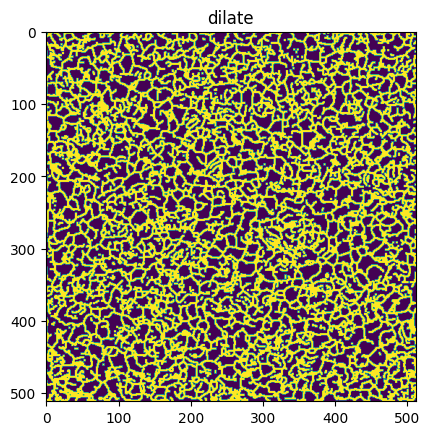

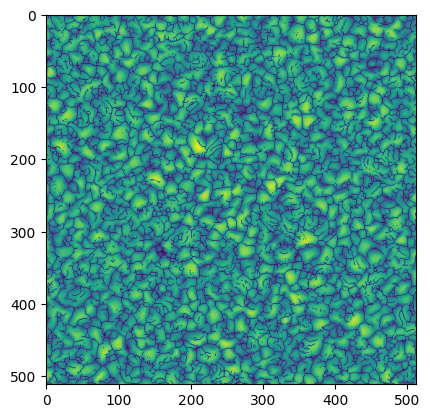

In [81]:
# img2 = cv2.medianBlur(img, 5)
# plot(img2, 'blur')
# img3 = cv2.bilateralFilter(img2, 9, 75, 75)
# plot(img3, 'bilateral filter')
img4 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 0)
plot(img, 'adaptive threshold')
img5 = skimage.img_as_ubyte(skimage.morphology.skeletonize(skimage.img_as_bool(img4)))
plot(img5, 'img as ubyte')
img6 = cv2.dilate(img5, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=1)
plot(img6, 'dilate')

edges = (img5 != 0)
masked_img = np.ma.masked_array(img, img5!=0, fill_value=5).filled()
plt.imshow(masked_img)
plt.show()

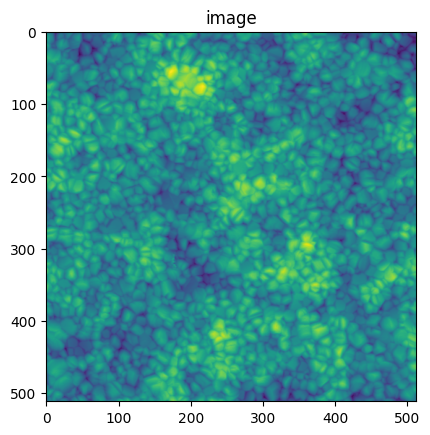

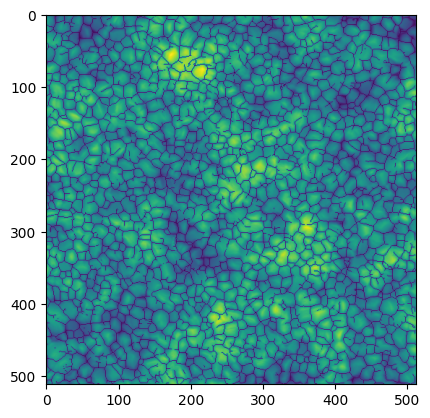

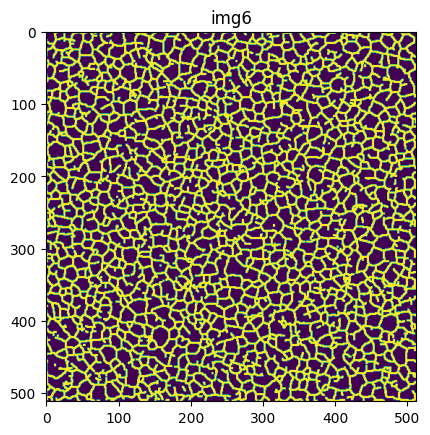

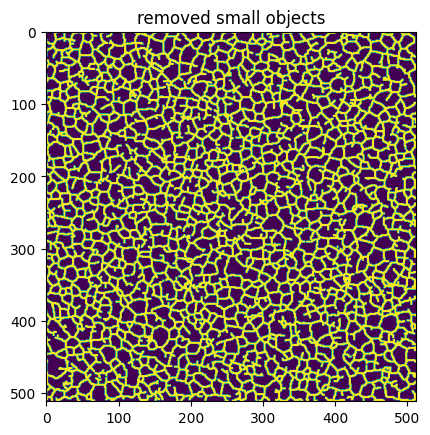

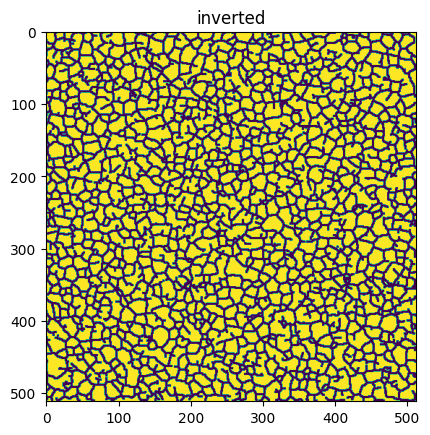

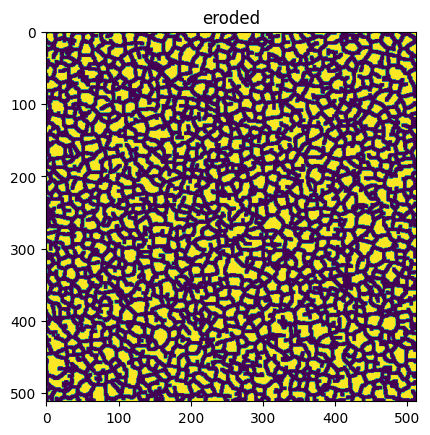

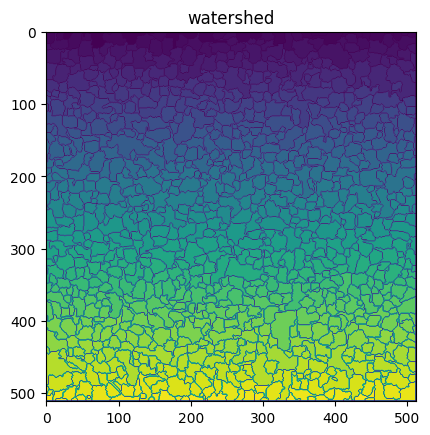

In [6]:
img = data.copy()
img = plane_tilt_removal(img)
img = scale_heightmap(img)
plot(img, 'image')
img4 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 27, 0)
img5 = skimage.img_as_ubyte(skimage.morphology.skeletonize(skimage.img_as_bool(img4)))
img6 = cv2.dilate(img5, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=1)
edges = (img5 != 0)
masked_img = np.ma.masked_array(img, edges, fill_value=5).filled()
plt.imshow(masked_img)
plt.show()

plot(img6, 'img6')

removed_small_objects = skimage.morphology.remove_small_objects(img6.astype(bool), min_size=100)
plot(removed_small_objects, 'removed small objects')

inverted = np.invert(removed_small_objects)
# inverted = cv2.erode(inverted)
plot(inverted, 'inverted')

# eroded = skimage.morphology.binary_erosion(inverted)
eroded = cv2.erode(inverted.astype(np.uint8), kernel=np.ones((3,3),np.uint8), iterations=1)
plot(eroded, 'eroded')

ret, markers = cv2.connectedComponents(np.uint8(eroded))

watershed = cv2.watershed(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), markers.astype(np.int32))
plot(watershed, 'watershed')

# sure_bg = np.invert(img5)
# plot(sure_bg, 'sure_background')

# kernel = np.ones((3,3),np.uint8)
# sure_fg = cv2.erode(sure_bg, kernel, iterations=1)
# sure_fg = cv2.morphologyEx(sure_fg, cv2.MORPH_CLOSE, kernel)

# dist_transform = cv2.distanceTransform(sure_bg, cv2.DIST_L2, 5)
# plot(dist_transform, 'distance transform')

# ret, sure_fg = cv2.threshold(dist_transform, 0.1*dist_transform.max(), 255, 0)
# plot(sure_fg, 'sure foreground')

# Find unknown region
# sure_fg = np.uint8(sure_fg)
# plot(sure_fg, 'sure foreground')
# unknown = cv2.subtract(sure_bg, sure_fg)
# plot(unknown, 'unknown')

# ret, markers = cv2.connectedComponents(sure_fg)
# plot(markers, 'markers')

# markers = markers + 1
# # markers[unknown==255] = 0
# markers = markers.astype(np.int32)

# Convert image to 3-channel colour
# img_3_channel = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
# plot(img_3_channel, 'img 3 channel')

# watershed_markers = cv2.watershed(img_3_channel, markers)
# plot(watershed_markers, 'watershed')

# fig, ax = plt.subplots(1, 2, figsize=(10,20))
# ax[0].imshow(img)
# ax[1].imshow(watershed_markers)
# plt.show()

# kernel = np.ones((3,3),np.uint8)
# opening = cv2.morphologyEx(inverted,cv2.MORPH_OPEN,kernel, iterations = 1)
# plot(opening, 'opening')

# sure_bg = cv2.dilate(opening, kernel, iterations=3)
# plot(sure_bg, 'sure_bg')

# inverted_edges = np.invert(edges)
# labelled = skimage.measure.label(inverted_edges, background=0, connectivity=1)

# num_labels, markers = cv2.connectedComponents(sure_bg, connectivity=4)
# plot(markers, 'labelled')

# labels_im = labels_im + 1

# watershed_markers = watershed = cv2.watershed(img, markers)
# plot(watershed_markers, 'watershed')


# plot(labelled[0:10, 0:10], 'labelled')
# print(labelled[0:10, 0:10])

# plot(labelled[440:450, 440:450], 'labelled')
# print(labelled[440:450, 440:450])

# print(inverted_edges)
# boolean_areas = (inverted_edges == 255).astype(int)
# print(boolean_areas)
# labels = cv2.connectedComponents(boolean_areas)
# print(labels)
# plot(labels[1])
